In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from scipy.stats import ttest_1samp

torch.manual_seed(42)

## Warm up

Let's toss a coin 10 times.

In [2]:
sample = np.random.binomial(10,0.5)

In [3]:
sample

5

Let's repeat this 10,000 times.

How many times will we see 10 heads and 0 tails?

In [4]:
nsim = 10000
nheads = np.zeros((nsim))

for i in range(nsim):
    sample = np.random.binomial(10,0.5)
    nheads[i] = sample

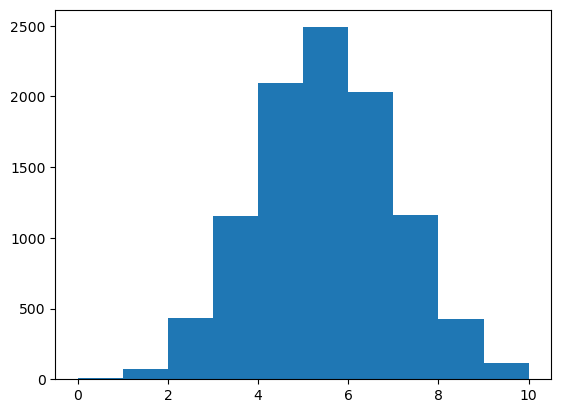

In [5]:
plt.hist(nheads);

In [6]:
sum(nheads == 0)

np.int64(9)

If we do enough tests, we will see rare things, even when the null hypothesis is true!

How do we account for this?

## Multiple testing

We run one-sample t-tests for $m$ hypotheses.

We do the following corrections:

- Bonferroni 
- Holms
- Benjamini-Hochberg

### Example: No actual signal

In [7]:
n = 40        # number of samples
m = 1000         # number of features

X = np.random.normal(size = (n, m))
#h0 is true

In [8]:
X[:, 0]

array([ 1.1590115 ,  0.29437799, -1.20388884, -1.39994129,  0.80287114,
       -0.66532837,  0.94760322, -1.02684096, -0.53667259,  1.26035408,
        0.30475883, -0.68428187, -0.7424497 , -1.19441991, -0.6307807 ,
        1.08867092,  0.65729084,  0.02539257,  1.05287459, -1.93841006,
        2.17832052, -2.4701497 ,  2.02294352,  0.06927303,  0.54318123,
        1.9602065 , -0.35964106,  1.04538793, -1.52884496,  0.34965436,
       -1.33769048,  0.6165512 ,  0.67023305, -1.11043292,  0.9638287 ,
       -0.46430343, -0.41250436, -0.30909244, -0.02039219, -0.3204189 ])

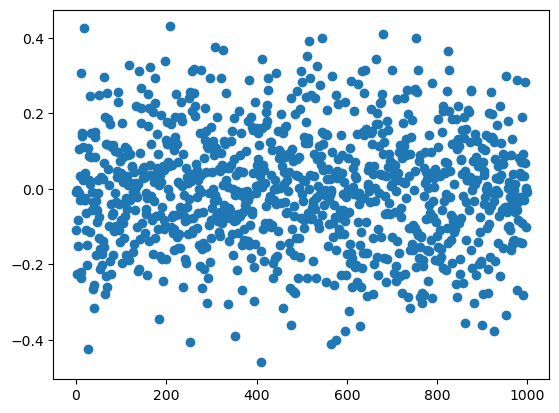

In [9]:
plt.scatter(range(m), X.mean(axis=0))

In [10]:
def ttest_1(x, h0_mean=0):

    df = n-1

    mean = x.mean() # sample mean x_bar
    d = mean - h0_mean # x_bar - mu   (mu=0 under H_0)
    v = np.var(x) # sample variance
    denom = np.sqrt(v / n) # variance of sample mean
    tstat = np.abs(d / denom)
    # xmean - h0_mean / (sqrt(var/n))

    # our test-stat is a t distributed random variable with n-1 degrees of freedom

    pval = t.cdf(-tstat, df = df) + (1 - t.cdf(tstat, df = df)) 

    # pval - probability in the lower and upper tails of our t distribution

    return pval

In [11]:
pvals = np.zeros((m))
for j in range(m):
    pvals[j] = ttest_1samp(X[:, j], 0).pvalue

In [12]:
# no multiple testing correction
# we expect to reject m * 0.05 samples
alpha  = 0.05
nmp = np.where(pvals < alpha)[0]
print("No multiple testing correction: reject ", nmp.shape[0])

No multiple testing correction: reject  45


In [13]:
# bonferroni
bf = np.where(pvals < alpha/m)[0]
print("Bonferroni: reject ", bf.shape[0])


Bonferroni: reject  0


In [14]:
# holms
ord_pvals = np.argsort(pvals)
holms = []
for j, s in enumerate(ord_pvals):
    #j = 0, s is index of smallest p-val
    denom = m - j
    if pvals[s] <= (alpha/denom):
        holms.append(s)
    else:
        break
print("Holms: reject ", len(holms))


Holms: reject  0


In [15]:
# BH procedure # this is different from holms and bonferroni in that 
# we control FDR, not FWER
q = 0.05
bh = []
for j, s in enumerate(ord_pvals):
    val = q * (j + 1) /m # zero indexing
    if pvals[s] <= val:
        bh.append(s)
    else:
        break

print("Benjamini-Hochberg: reject ", len(bh))

Benjamini-Hochberg: reject  0


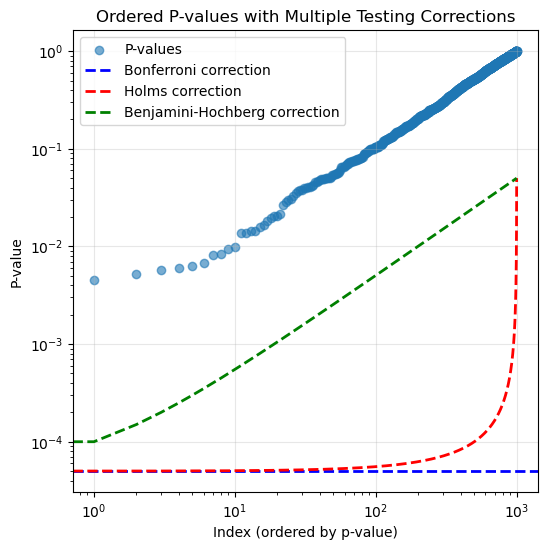

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(range(m), pvals[ord_pvals], alpha=0.6, label='P-values')

plt.axhline(y=alpha/m, color='b', linestyle='--', label='Bonferroni correction', linewidth=2)
# Holms correction line
holms_threshold = alpha / (m - np.arange(m))
plt.plot(range(m), holms_threshold, 'r--', label='Holms correction', linewidth=2)

# Benjamini-Hochberg correction line
bh_threshold = (alpha / m) * (np.arange(m) + 1)
plt.plot(range(m), bh_threshold, 'g--', label='Benjamini-Hochberg correction', linewidth=2)

plt.xlabel('Index (ordered by p-value)')
plt.ylabel('P-value')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title('Ordered P-values with Multiple Testing Corrections')
plt.grid(True, alpha=0.3)
plt.show()

### Example: Some signal to detect

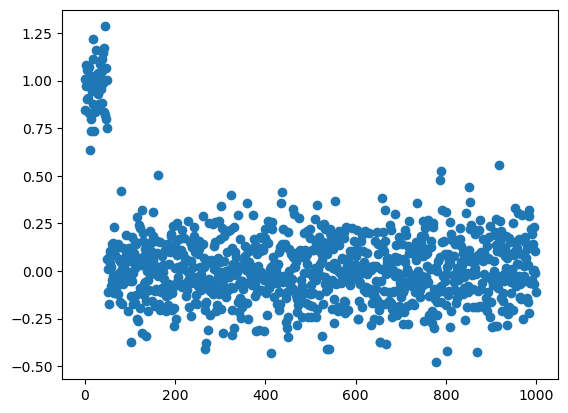

In [17]:
true_mean = np.array([1.0] * int(m*5/100) + [0] * int(m * 95/100))

X = np.random.normal(size = (n, m))
X = X + true_mean

plt.scatter(range(m), X.mean(axis=0))

In [18]:
print('Number of hypotheses we should reject: ', int(m * 5/100))

Number of hypotheses we should reject:  50


In [19]:
pvals = np.zeros((m))
for j in range(m):
    pvals[j] = ttest_1samp(X[:, j], 0).pvalue

In [20]:
# no multiple testing correction
alpha  = 0.05
nmp = np.where(pvals < alpha)[0]
print("No multiple testing correction: reject ", nmp.shape[0])

No multiple testing correction: reject  94


In [21]:
# bonferroni
bon = np.where(pvals < alpha/m)[0]
print("Bonferroni: reject ", bon.shape[0])


Bonferroni: reject  46


In [22]:

# holms
ord_pvals = np.argsort(pvals)
holms = []
for j, s in enumerate(ord_pvals):
    denom = m - j
    if pvals[s] <= (alpha/denom):
        holms.append(s)
    else:
        break
print("Holms: reject ", len(holms))

Holms: reject  46


In [23]:
# BH procedure
q = 0.05
bh = []
for j, s in enumerate(ord_pvals):
    val = q * (j + 1) /m # zero indexing
    if pvals[s] <= val:
        bh.append(s)
    else:
        break

print("Benjamini-Hochberg: reject ", len(bh))

Benjamini-Hochberg: reject  55


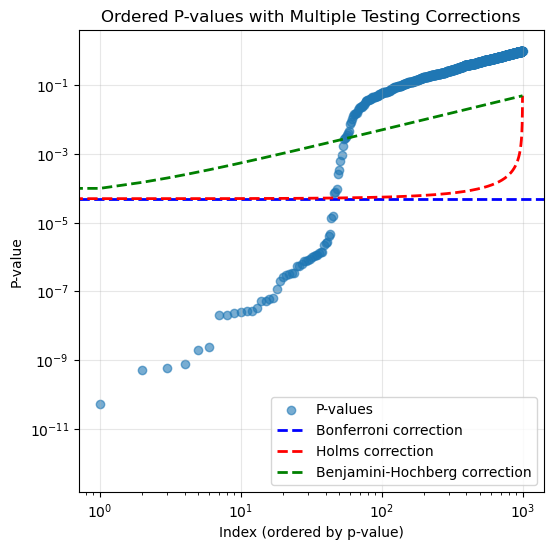

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(range(m), pvals[ord_pvals], alpha=0.6, label='P-values')

plt.axhline(y=alpha/m, color='b', linestyle='--', label='Bonferroni correction', linewidth=2)
# Holms correction line
holms_threshold = alpha / (m - np.arange(m))
plt.plot(range(m), holms_threshold, 'r--', label='Holms correction', linewidth=2)

# Benjamini-Hochberg correction line
bh_threshold = (alpha / m) * (np.arange(m) + 1)
plt.plot(range(m), bh_threshold, 'g--', label='Benjamini-Hochberg correction', linewidth=2)

plt.xlabel('Index (ordered by p-value)')
plt.ylabel('P-value')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Ordered P-values with Multiple Testing Corrections')
plt.grid(True, alpha=0.3)
plt.show()